# Quoridor Search Assignment — Minimax, Alpha–Beta, Move Ordering, Heuristics

**Goals**  
1) Implement **Minimax** (no pruning), **Alpha–Beta**, and **Alpha–Beta with Move Ordering** for Quoridor.  
2) Design at least **two evaluation heuristics** and compare their effects.  
3) Run **AI vs AI experiments** and report **nodes expanded**, **time per move**, and **win rate**.  

> You may work on a reduced board size (e.g., 7×7) to speed up experiments. The provided engine is intentionally compact and documented.

## 0. Setup

Run the next cell to import packages and set a random seed.

In [3]:
import math, random, time
from collections import deque, defaultdict
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

print("Ready. Python:", __import__('sys').version.split()[0])


Ready. Python: 3.10.14


## 1. Quoridor Engine (Provided)

- Board of size `N×N` (default **9**; you may reduce to **7** or **5** for speed).  
- Two pawns (players **0** and **1**).  
- Each has `walls_left` walls (default **10**; tune for speed).  
- On a turn, a player either **moves** (orthogonally; with jump over rules) or **places a wall** (2 cells long) subject to legality:
  - cannot overlap/cross existing walls,
  - cannot eliminate all paths to the opponent's goal.

> The engine exposes: `legal_pawn_moves`, `legal_wall_moves`, `apply`, `undo`, `winner`, and **BFS distance** helpers.

In [4]:
from dataclasses import dataclass
from typing import List, Tuple, Optional, Set, Dict

Coord = Tuple[int,int]          # (r,c)
Wall  = Tuple[int,int,str]      # (r,c,'H'|'V')

@dataclass(frozen=True)
class Move:
    kind: str            # 'PAWN' or 'WALL'
    to: Optional[Coord] = None
    wall: Optional[Wall] = None

    @staticmethod
    def pawn(to: Coord): return Move('PAWN', to=to)
    @staticmethod
    def wall(r:int,c:int,o:str): return Move('WALL', wall=(r,c,o))

class Board:
    def __init__(self, N:int=9):
        self.N=N
        self.h_walls:set[Tuple[int,int]] = set()
        self.v_walls:set[Tuple[int,int]] = set()

    def wall_legal(self, w:Wall)->bool:
        r,c,o = w
        if not (0<=r<self.N-1 and 0<=c<self.N-1): return False
        if o=='H':
            if (r,c) in self.h_walls: return False             # exact overlap
            if (r,c) in self.v_walls: return False             # cross at anchor
            if (r,c-1) in self.h_walls or (r,c+1) in self.h_walls: return False  # half-overlap
        else:
            if (r,c) in self.v_walls: return False
            if (r,c) in self.h_walls: return False
            if (r-1,c) in self.v_walls or (r+1,c) in self.v_walls: return False
        return True

    def place_wall(self, w:Wall):
        assert self.wall_legal(w), f"Illegal wall {w}"
        r,c,o=w
        (self.h_walls if o=='H' else self.v_walls).add((r,c))

    def remove_wall(self, w:Wall):
        r,c,o=w
        (self.h_walls if o=='H' else self.v_walls).discard((r,c))

    def _blocked_edge(self, a:Coord, b:Coord)->bool:
        ar,ac=a; br,bc=b
        if ar==br:
            if abs(ac-bc)!=1: return True
            cmin=min(ac,bc)
            return (ar,cmin) in self.v_walls or (ar-1,cmin) in self.v_walls
        if ac==bc:
            if abs(ar-br)!=1: return True
            rmin=min(ar,br)
            return (rmin,ac) in self.h_walls or (rmin,ac-1) in self.h_walls
        return True

    def neighbors(self, p:Coord)->List[Coord]:
        r,c=p; N=self.N
        cand=[]
        if r>0:     cand.append((r-1,c))
        if r+1<N:   cand.append((r+1,c))
        if c>0:     cand.append((r,c-1))
        if c+1<N:   cand.append((r,c+1))
        return [q for q in cand if not self._blocked_edge(p,q)]

    # BFS distance to any goal row in 'goal_rows'
    def bfs_dist(self, start:Coord, goal_rows:Set[int])->Optional[int]:
        seen={start}; from collections import deque
        q=deque([(start,0)])
        while q:
            u,d=q.popleft()
            if u[0] in goal_rows: return d
            for v in self.neighbors(u):
                if v not in seen:
                    seen.add(v); q.append((v,d+1))
        return None

    # First step of a BFS shortest path; returns (dist, next_step)
    def bfs_next(self, start:Coord, goal_rows:Set[int]):
        parent={}; seen={start}; from collections import deque
        q=deque([start])
        while q:
            u=q.popleft()
            if u[0] in goal_rows:
                # reconstruct first step
                cur=u
                while cur in parent and parent[cur]!=start:
                    cur=parent[cur]
                # distance:
                d=0; t=u
                while t in parent:
                    d+=1; t=parent[t]
                next_step = start if cur==start else cur
                return d, next_step
            for v in self.neighbors(u):
                if v not in seen:
                    seen.add(v); parent[v]=u; q.append(v)
        return None, None

class GameState:
    def __init__(self, N:int=9, walls:int=10):
        self.board=Board(N)
        self.N=N
        self.pawns=[(0,N//2),(N-1,N//2)]
        self.walls_left=[walls,walls]
        self.to_move=0
        self.history=[]  # snapshots for undo

    def goal_rows(self, player:int)->set:
        return {self.N-1} if player==0 else {0}

    def in_bounds(self, p:Coord)->bool:
        r,c=p; return 0<=r<self.N and 0<=c<self.N

    def legal_pawn_moves(self)->List[Coord]:
        me=self.to_move; you=1-me
        myp=self.pawns[me]; opp=self.pawns[you]
        out=[]
        for q in self.board.neighbors(myp):
            if q==opp:
                dr=opp[0]-myp[0]; dc=opp[1]-myp[1]
                dest=(opp[0]+dr,opp[1]+dc)
                if self.in_bounds(dest) and not self.board._blocked_edge(opp,dest):
                    out.append(dest)
                else:
                    for d in [(-1,0),(1,0),(0,-1),(0,1)]:
                        side=(opp[0]+d[0],opp[1]+d[1])
                        if self.in_bounds(side) and not self.board._blocked_edge(opp,side) and not self.board._blocked_edge(myp,opp):
                            out.append(side)
            else:
                out.append(q)
        return list(dict.fromkeys(out))

    def legal_wall_moves(self)->List[Wall]:
        me=self.to_move
        if self.walls_left[me]<=0: return []
        N=self.N; cand=[]
        for r in range(N-1):
            for c in range(N-1):
                for o in ('H','V'):
                    w=(r,c,o)
                    if not self.board.wall_legal(w):
                        continue
                    self.board.place_wall(w)
                    ok = (self.board.bfs_dist(self.pawns[0], self.goal_rows(0)) is not None and
                          self.board.bfs_dist(self.pawns[1], self.goal_rows(1)) is not None)
                    self.board.remove_wall(w)
                    if ok: cand.append(w)
        return cand

    def legal_moves(self)->List[Move]:
        return [Move.pawn(p) for p in self.legal_pawn_moves()] + \
               [Move.wall(*w) for w in self.legal_wall_moves()]

    def snapshot(self):
        return (tuple(self.pawns),
                tuple(sorted(self.board.h_walls)),
                tuple(sorted(self.board.v_walls)),
                tuple(self.walls_left),
                self.to_move)

    def restore(self, snap):
        pawns,hws,vws,wl,tm = snap
        self.pawns=list(pawns)
        self.board.h_walls=set(hws)
        self.board.v_walls=set(vws)
        self.walls_left=list(wl)
        self.to_move=tm

    def apply(self, mv:Move):
        self.history.append(self.snapshot())
        if mv.kind=='PAWN':
            assert mv.to in self.legal_pawn_moves(), f"Illegal pawn {mv.to}"
            me=self.to_move
            self.pawns[me]=mv.to
        else:
            w=mv.wall
            assert w in self.legal_wall_moves(), f"Illegal wall {w}"
            self.board.place_wall(w)
            self.walls_left[self.to_move]-=1
        self.to_move^=1

    def undo(self):
        if not self.history: return
        self.restore(self.history.pop())

    def winner(self)->Optional[int]:
        if self.pawns[0][0]==self.N-1: return 0
        if self.pawns[1][0]==0: return 1
        return None

    def evaluate(self)->float:
        d0 = self.board.bfs_dist(self.pawns[0], self.goal_rows(0))
        d1 = self.board.bfs_dist(self.pawns[1], self.goal_rows(1))
        if d0 is None or d1 is None: return 0.0
        return (d1 - d0)*10.0 + (self.walls_left[0]-self.walls_left[1])*0.5

def greedy_shortest_pawn_move(state, side:int):
    """
    Return the pawn move that most reduces BFS distance to the side's goal rows.
    Ties break by forward progress, then centrality. Returns None if no pawn moves.
    """
    goals = state.goal_rows(side)              # your function that returns the goal row set for a side
    r0, c0 = state.pawns[side]
    mid = state.N // 2
    toward = +1 if side == 0 else -1

    pawn_moves = [mv for mv in state.legal_moves() if mv.kind == 'PAWN']
    if not pawn_moves:
        return None

    best_mv = None
    best_key = (math.inf, )  # will store (dist, -progress, center)

    for mv in pawn_moves:
        r, c = mv.to
        # distance *from the landing cell* to the goal rows
        dist = state.board.bfs_dist((r, c), goals)
        if dist is None:
            dist = 99  # unreachable fallback

        progress = toward * (r - r0)           # prefer stepping forward
        center   = abs(c - mid)                 # prefer central lanes as tiebreaker

        key = (dist, -progress, center)
        if key < best_key:
            best_key, best_mv = key, mv

    return best_mv


### Quick smoke test

In [5]:
s=GameState(N=7, walls=6)
print("Legal pawn moves at start:", s.legal_pawn_moves())
print("Legal wall moves (count):", len(s.legal_wall_moves()))
print("Eval:", s.evaluate())


Legal pawn moves at start: [(1, 3), (0, 2), (0, 4)]
Legal wall moves (count): 72
Eval: 0.0


## 2. Minimax (No Pruning)

**Task A:** Implement plain minimax with depth limit.  
- Return `(value, move)`.  
- Count visited nodes in a global or passed-in counter for later analysis.

In [6]:
# TODO: Implement minimax (no pruning)

import math

def _eval_for_player(state: GameState, player: int) -> float:
    """
    If state.evaluate() is Blue-centric (P0 better -> higher),
    flip the sign when scoring for Red so value is from `player`'s POV.
    """
    e = state.evaluate()
    return e if player == 0 else -e

def minimax(state: GameState, depth: int, root_player: int, counter: dict):
    """
    Classic minimax that ALWAYS evaluates from `root_player`'s perspective.
    Maximize when it's root_player's turn; minimize otherwise.
    Returns (value, move).
    """
    counter['nodes'] = counter.get('nodes', 0) + 1

    w = state.winner()
    if w is not None:
        # Win/loss from root player's POV
        return ((+1e6) if w == root_player else (-1e6), None)

    if depth == 0:
        return (_eval_for_player(state, root_player), None)

    moves = state.legal_moves()
    if not moves:
        # Stalemate-like: treat as leaf from root player's POV
        return (_eval_for_player(state, root_player), None)

    maximizing = (state.to_move == root_player)

    best_val = -math.inf if maximizing else math.inf
    best_mv = None
    for mv in moves:
        snap = state.snapshot()
        state.apply(mv)
        val, _ = minimax(state, depth - 1, root_player, counter)
        state.restore(snap)

        if maximizing:
            if val > best_val:
                best_val, best_mv = val, mv
        else:
            if val < best_val:
                best_val, best_mv = val, mv

    return best_val, best_mv


# c={}; val,mv=minimax(GameState(N=5,walls=4), depth=2, maximizing=True, counter=c); val, mv, c


## 3. Alpha–Beta Pruning

**Task B:** Implement alpha–beta using the minimax formulation.  
- Return `(value, move)`.  
- Maintain a **node counter** and optionally a **prune counter**.

In [7]:
import math

def alphabeta(state: GameState, depth: int, alpha: float, beta: float,
              root_player: int, counter: dict):
    """
    Alpha–beta search that ALWAYS evaluates from `root_player`'s perspective.
    Maximizes when it's root_player's turn; minimizes otherwise.
    Returns (value, move).
    """
    counter['nodes'] = counter.get('nodes', 0) + 1

    w = state.winner()
    if w is not None:
        # Win/loss from root player's POV
        return ((+1e6) if w == root_player else (-1e6), None)

    if depth == 0:
        return (_eval_for_player(state, root_player), None)

    moves = state.legal_moves()
    if not moves:
        # Treat no-legal-move non-terminal as leaf
        return (_eval_for_player(state, root_player), None)

    maximizing = (state.to_move == root_player)
    best_mv = None

    if maximizing:
        v = -math.inf
        for mv in moves:
            snap = state.snapshot()
            state.apply(mv)
            val, _ = alphabeta(state, depth - 1, alpha, beta, root_player, counter)
            state.restore(snap)

            if val > v:
                v, best_mv = val, mv
            if v > alpha:
                alpha = v
            if alpha >= beta:
                counter['prunes'] = counter.get('prunes', 0) + 1
                break
        return v, best_mv
    else:
        v = math.inf
        for mv in moves:
            snap = state.snapshot()
            state.apply(mv)
            val, _ = alphabeta(state, depth - 1, alpha, beta, root_player, counter)
            state.restore(snap)

            if val < v:
                v, best_mv = val, mv
            if v < beta:
                beta = v
            if alpha >= beta:
                counter['prunes'] = counter.get('prunes', 0) + 1
                break
        return v, best_mv


## 4. Move Ordering

**Task C:** Add move ordering and compare.  
- Implement `ordered_moves(state)` that scores moves roughly (e.g., prefer pawn moves that reduce own distance and increase opponent's).  
- Use this in your alpha–beta search to maximize pruning.

In [8]:
# TODO: Implement a move ordering heuristic
def ordered_moves(state: GameState):
    me=state.to_move; you=1-me
    my_goal=state.goal_rows(me); opp_goal=state.goal_rows(you)
    moves=state.legal_moves()
    scored=[]
    for mv in moves:
        snap=state.snapshot(); state.apply(mv)
        dme=state.board.bfs_dist(state.pawns[me], my_goal) or 99
        dyo=state.board.bfs_dist(state.pawns[you], opp_goal) or 99
        score=(dyo - dme)    # higher is better
        state.restore(snap)
        if mv.kind=='PAWN': score += 0.25
        scored.append((score,mv))
    scored.sort(key=lambda x:x[0], reverse=True)
    return [m for _,m in scored]


def alphabeta_ordered(state: GameState, depth: int, alpha: float, beta: float,
                      root_player: int, counter: dict):
    """
    Alpha–beta with move ordering, evaluated from `root_player`'s POV.
    Maximize when state.to_move == root_player, else minimize.
    Returns (value, move).
    """
    counter['nodes'] = counter.get('nodes', 0) + 1

    w = state.winner()
    if w is not None:
        # terminal from root player's POV
        return ((+1e6) if w == root_player else (-1e6), None)

    if depth == 0:
        return (_eval_for_player(state, root_player), None)

    mv_list = ordered_moves(state)   # your heuristic ordering
    if not mv_list:
        # treat no-legal-move non-terminal as leaf
        return (_eval_for_player(state, root_player), None)

    maximizing = (state.to_move == root_player)
    best_mv = None

    if maximizing:
        v = -math.inf
        for mv in mv_list:
            snap = state.snapshot()
            state.apply(mv)
            val, _ = alphabeta_ordered(state, depth - 1, alpha, beta, root_player, counter)
            state.restore(snap)

            if val > v:
                v, best_mv = val, mv
            if v > alpha:
                alpha = v
            if alpha >= beta:
                counter['prunes'] = counter.get('prunes', 0) + 1
                break
        return v, best_mv
    else:
        v = math.inf
        for mv in mv_list:
            snap = state.snapshot()
            state.apply(mv)
            val, _ = alphabeta_ordered(state, depth - 1, alpha, beta, root_player, counter)
            state.restore(snap)

            if val < v:
                v, best_mv = val, mv
            if v < beta:
                beta = v
            if alpha >= beta:
                counter['prunes'] = counter.get('prunes', 0) + 1
                break
        return v, best_mv

## 5. Your Heuristics (Design & Compare)

**Task D:** Implement at least **two** evaluation functions and compare them:
- `eval_distance_only` – distance diff only.
- `eval_mixed` – distance diff + walls + (optional) anti-backtrack or center control.

Plug them into searches to compare strength and speed.

In [11]:
# TODO: Design your heuristics
def eval_distance_only(state: GameState)->float:
    d0=state.board.bfs_dist(state.pawns[0], state.goal_rows(0))
    d1=state.board.bfs_dist(state.pawns[1], state.goal_rows(1))
    if d0 is None or d1 is None: return 0.0
    return (d1-d0)*10.0

def eval_mixed(state: GameState)->float:
    # Example mix: distance diff + walls + mild centralization
    d0=state.board.bfs_dist(state.pawns[0], state.goal_rows(0))
    d1=state.board.bfs_dist(state.pawns[1], state.goal_rows(1))
    if d0 is None or d1 is None: return 0.0
    dist=(d1-d0)*10.0
    walls=(state.walls_left[0]-state.walls_left[1])*0.6
    mid=state.N//2
    cen = - (abs(state.pawns[0][1]-mid) - abs(state.pawns[1][1]-mid)) * 0.2
    return dist + walls + cen

# Hook to switch evaluation for all searches below
CURRENT_EVAL = eval_mixed

# Patch GameState.evaluate to call CURRENT_EVAL
GameState.evaluate = lambda self: CURRENT_EVAL(self)


## 6. Match Harness (AI vs AI)

Use this to pit strategies against each other and collect metrics.

In [10]:
import math, time
from collections import defaultdict

# ---------- ASCII Board Renderer ----------
def render_board_ascii(state):
    """
    Pretty-prints the Quoridor position as ASCII.
    Legend:
      B = Blue (P0) pawn
      R = Red  (P1) pawn
      ─ and │ = walls between cells (drawn with Unicode for clarity)
      · = empty cell
    """
    N = state.N
    B = set(state.board.h_walls)     # horizontal walls keyed as (r, c)
    V = set(state.board.v_walls)     # vertical walls keyed as (r, c)

    # Fast lookups for pawns
    (r0, c0) = state.pawns[0]
    (r1, c1) = state.pawns[1]

    lines = []
    # Column indices header
    col_idx = "    " + "  ".join(f"{c:2d}" for c in range(N))
    lines.append(col_idx)

    for r in range(N):
        # Row of cells with vertical separators in between
        row_cells = [f"{r:2d}  "]  # row index at the start

        for c in range(N):
            # Cell char
            if (r, c) == (r0, c0):
                ch = "B"
            elif (r, c) == (r1, c1):
                ch = "R"
            else:
                ch = "·"

            row_cells.append(f" {ch}")

            # Vertical seam to the right of (r,c): is there a vertical wall blocking c->c+1?
            if c < N - 1:
                # A vertical wall segment between (r,c) and (r,c+1) is recorded as:
                # V contains (r, c) OR V contains (r-1, c)
                if (r, c) in V or (r - 1, c) in V:
                    row_cells.append(" │")   # wall
                else:
                    row_cells.append("  ")   # open seam

        lines.append("".join(row_cells))

        # Horizontal seam below row r (between r and r+1)
        if r < N - 1:
            seam = ["    "]
            for c in range(N):
                # Horizontal wall between (r,c) and (r+1,c) is recorded as:
                # B contains (r, c) OR B contains (r, c-1)
                if (r, c) in B or (r, c - 1) in B:
                    seam.append("───")
                else:
                    seam.append("   ")
                # Small cross for intersections (doesn't affect walls)
                if c < N - 1:
                    seam.append("┼")
            lines.append("".join(seam))

    # HUD line (turn + walls)
    turn = "Blue (P0)" if state.to_move == 0 else "Red (P1)"
    hud = f"\nTurn: {turn} | Walls Left: P0={state.walls_left[0]}  P1={state.walls_left[1]}"
    lines.append(hud)
    return "\n".join(lines)

# ---------- Game loop with side-selectable engines ----------
import math, time, random
from collections import defaultdict

def play_game(
    N=7,
    walls=6,
    depth=3,
    engines="ab",                  # str | dict: {0: 'ab', 1: 'minimax'} etc.
    verbose=False,
    sleep_sec=0.0,
):
    """
    Runs a full game with selectable engines per side and a greedy override:
    if the current side has 0 walls left, pick the pawn step that most reduces
    BFS distance to its goal (ties: forward progress, then centrality).

    Returns:
      (winner, nodes, prunes, times)
    """
    # Normalize engine selection
    if isinstance(engines, str):
        side_engine = {0: engines, 1: engines}
    else:
        side_engine = {0: engines.get(0, "ab"), 1: engines.get(1, "ab")}

    # --- helpers ---
    def _engine_label(side):
        return ("blue" if side == 0 else "red") + f":{side_engine[side]}"

    def greedy_shortest_pawn_move(state, side:int):
        """Choose the pawn move that most reduces BFS distance to goal."""
        goals = state.goal_rows(side)
        r0, c0 = state.pawns[side]
        mid = state.N // 2
        toward = +1 if side == 0 else -1

        pawn_moves = [mv for mv in state.legal_moves() if mv.kind == 'PAWN']
        if not pawn_moves:
            return None

        best_mv, best_key = None, (math.inf, )  # (dist, -progress, center)
        for mv in pawn_moves:
            r, c = mv.to
            dist = state.board.bfs_dist((r, c), goals)
            if dist is None:
                dist = 99
            progress = toward * (r - r0)
            center = abs(c - mid)
            key = (dist, -progress, center)
            if key < best_key:
                best_key, best_mv = key, mv
        return best_mv

    def _search_move(state, side):
        """Run the chosen policy for the current side (greedy override, else engine)."""
        eng = side_engine[side]

        # --- Greedy override when this side has no walls left ---
        if state.walls_left[side] == 0:
            mv = greedy_shortest_pawn_move(state, side)
            if mv is not None:
                times[_engine_label(side)].append(0.0)  # record a near-zero time
                return mv
            # fall through if no pawn moves exist

        # --- Otherwise, use the chosen engine ---
        cnt = {}
        t0 = time.time()

        # With turn-relative leaves, root can start as maximizing=True
        if eng == "minimax":
            val, mv = minimax(state, depth, root_player=side, counter=cnt)
        elif eng == "ab":
            val, mv = alphabeta(state, depth, -math.inf, math.inf,
                                root_player=side, counter=cnt)
        elif eng == "ab_ordered":
            val, mv = alphabeta_ordered(state, depth, -math.inf, math.inf,
                                        root_player=side, counter=cnt)
        elif eng == "random":
            lm = state.legal_moves()
            mv = random.choice(lm) if lm else None
        else:
            raise ValueError("engine must be one of: minimax, ab, ab_ordered, random")

        dt = time.time() - t0
        lab = _engine_label(side)
        nodes[lab]  += cnt.get("nodes", 0)
        prunes[lab] += cnt.get("prunes", 0)
        times[lab].append(dt)
        return mv

    # --- init ---
    s = GameState(N=N, walls=walls)
    nodes  = defaultdict(int)
    prunes = defaultdict(int)
    times  = defaultdict(list)

    if verbose:
        print("Initial position:")
        print(render_board_ascii(s))
        print(f"Blue(P0) engine = {side_engine[0]} | Red(P1) engine = {side_engine[1]}")

    # --- main loop ---
    ply = 0
    while s.winner() is None:
        side = s.to_move  # 0 = Blue, 1 = Red
        mv = _search_move(s, side)

        if mv is None:
            lm = s.legal_moves()
            if not lm:
                break
            mv = lm[0]

        s.apply(mv)

        if verbose:
            ply += 1
            if mv.kind == "PAWN":
                desc = f"PAWN -> {mv.to}"
            else:
                r, c, o = mv.wall
                desc = f"WALL -> (r={r}, c={c}, o={o})"
            actor = "Blue(P0)" if side == 0 else "Red(P1)"
            print(f"\nPly {ply} by {actor} [{side_engine[side]}]: {desc}")
            print(render_board_ascii(s))
            if sleep_sec > 0:
                time.sleep(sleep_sec)

    w = s.winner()
    if verbose:
        print("\nGame Over.")
        if w is None:
            print("Winner: None (draw/blocked)")
        else:
            print("Winner:", "Blue (P0)" if w == 0 else "Red (P1)")
        for lab, lst in times.items():
            avg_ms = 1000 * (sum(lst) / max(1, len(lst)))
            print(f"Stats[{lab}]: nodes={nodes[lab]} prunes={prunes[lab]} avg_ms/move={avg_ms:.1f}")

    return w, nodes, prunes, times

# ---------- Example quick run ----------
# Tip: For readable output, try N=7, depth=2, and sleep_sec=0.2
w, nodes, prunes, times = play_game(N=5, walls=4, depth=2,
                                    engines={0: 'ab_ordered', 1: 'ab'},
                                    verbose=True)


Initial position:
     0   1   2   3   4
 0   ·   ·   B   ·   ·
       ┼   ┼   ┼   ┼   
 1   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 2   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 3   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 4   ·   ·   R   ·   ·

Turn: Blue (P0) | Walls Left: P0=4  P1=4
Blue(P0) engine = ab_ordered | Red(P1) engine = ab

Ply 1 by Blue(P0) [ab_ordered]: PAWN -> (1, 2)
     0   1   2   3   4
 0   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 1   ·   ·   B   ·   ·
       ┼   ┼   ┼   ┼   
 2   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 3   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 4   ·   ·   R   ·   ·

Turn: Red (P1) | Walls Left: P0=4  P1=4

Ply 2 by Red(P1) [ab]: PAWN -> (3, 2)
     0   1   2   3   4
 0   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 1   ·   ·   B   ·   ·
       ┼   ┼   ┼   ┼   
 2   ·   ·   ·   ·   ·
       ┼   ┼   ┼   ┼   
 3   ·   ·   R   ·   ·
       ┼   ┼   ┼   ┼   
 4   ·   ·   ·   ·   ·

Turn: Blue (P0) | Walls Left: P0=4  P1=4

Ply 3 by Blue(P0

## 7. Experiments

**Task E:** Fill the table by running matches under different settings.
- Compare **minimax**, **alpha–beta**, and **alpha–beta + ordering**.
- Try **two heuristics**: `eval_distance_only` vs `eval_mixed` (set `CURRENT_EVAL` accordingly).
- Record nodes expanded, prunes, avg move time, and winner rate across ~10–20 games (small boards/depth).

In [12]:
def benchmark(engines=('minimax','ab','ab_ordered'), games=6, N=5, walls=4, depth=2):
    results = []
    global CURRENT_EVAL

    for eval_name, E in [('distance', eval_distance_only), ('mixed', eval_mixed)]:
        CURRENT_EVAL = E
        for eng in engines:
            wins_blue, wins_red = 0, 0
            total_nodes = 0
            total_prunes = 0
            total_time = 0.0
            total_moves = 0

            for g in range(games):
                # play both sides with the same engine (engines param, not engine)
                w, n, p, t = play_game(N=N, walls=walls, depth=depth,
                                       engines=eng,  # same engine for Blue & Red
                                       verbose=False)

                if w == 0:
                    wins_blue += 1
                elif w == 1:
                    wins_red += 1

                # aggregate per-side stats
                for side in ('blue', 'red'):
                    key = f'{side}:{eng}'
                    total_nodes  += n.get(key, 0)
                    total_prunes += p.get(key, 0)
                    lst = t.get(key, [])
                    total_time   += sum(lst)
                    total_moves  += len(lst)

            avg_nodes = total_nodes / max(1, games)
            avg_prunes = total_prunes / max(1, games)
            avg_ms = 1000.0 * (total_time / max(1, total_moves))

            results.append((eval_name, eng, wins_blue, wins_red, avg_nodes, avg_prunes, avg_ms))

    return results

# Example:
res = benchmark(engines=('minimax','ab','ab_ordered'), games=4, N=6, walls=5, depth=3)
for row in res:
    print(row)

('distance', 'minimax', 4, 0, 1330862.0, 0.0, 75054.24494704892)
('distance', 'ab', 4, 0, 79263.0, 6611.0, 3903.792867737432)
('distance', 'ab_ordered', 0, 4, 26214.0, 1371.0, 9446.794937054316)
('mixed', 'minimax', 0, 4, 893997.0, 0.0, 87178.36524049442)
('mixed', 'ab', 0, 4, 47565.0, 2985.0, 4359.534884492557)
('mixed', 'ab_ordered', 0, 4, 26484.0, 1370.0, 9495.446304480234)


## 8. Plotting (Optional)

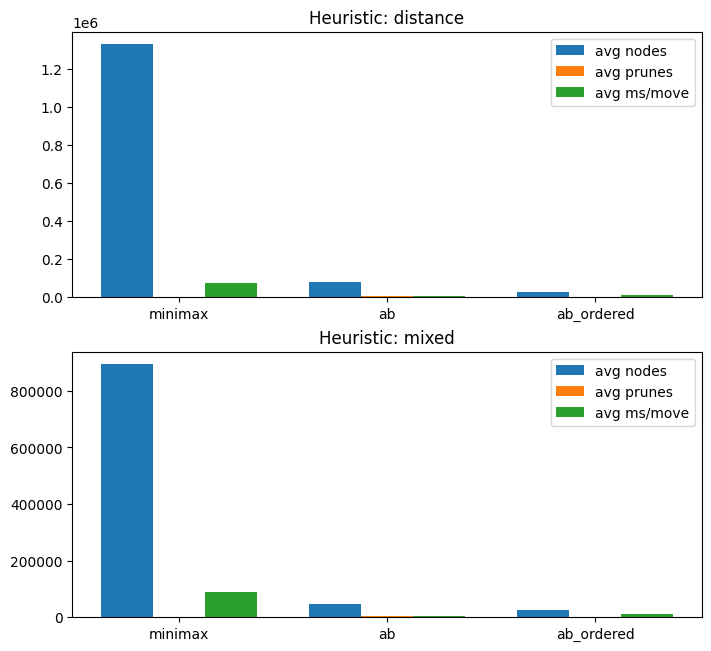

In [13]:
def plot_results(rows):
    cats = {}
    for (ev,eng,w0,w1,n,p,ms) in rows:
        cats.setdefault(ev, []).append((eng,n,p,ms,w0,w1))
    fig, axes = plt.subplots(len(cats), 1, figsize=(7, 3.2*len(cats)), constrained_layout=True)
    if len(cats)==1: axes=[axes]
    for ax,(ev,vals) in zip(axes, cats.items()):
        engines=[v[0] for v in vals]
        nodes=[v[1] for v in vals]
        prunes=[v[2] for v in vals]
        ms    =[v[3] for v in vals]
        x=np.arange(len(engines))
        ax.bar(x-0.25, nodes, width=0.25, label='avg nodes')
        ax.bar(x,      prunes, width=0.25, label='avg prunes')
        ax.bar(x+0.25, ms, width=0.25, label='avg ms/move')
        ax.set_xticks(x); ax.set_xticklabels(engines)
        ax.set_title(f"Heuristic: {ev}")
        ax.legend()
    plt.show()

plot_results(res)


## 9. Discussion (Write-up)

**Task F:** In 2–4 paragraphs:
- Compare the three search methods across your experiments.
- Analyze how move ordering changed the **alpha–beta** node counts.
- Compare your heuristics: where do they help? any failure cases?
- If you implemented extra ideas (iterative deepening, repetition tables, etc.), discuss their impact.